# Deduplication

This notebook shows the deduplication process for an example EM volume. A more comprehensive and scripted version of this same workflow exists in datasets/dededuplicated/deduplicate.py.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import SimpleITK as sitk
import imagehash
from PIL import Image
from matplotlib import pyplot as plt

In [75]:
#read in the tif example volume
#if testing another volume, just change this next line
#to point to its filepath
vol = sitk.ReadImage('example_data/CEE_CMM_Dedupe_Example.tif')
#convert it to a numpy array
vol = sitk.GetArrayFromImage(vol)
print('Volume of size:', vol.shape)

Volume of size: (224, 224, 224)


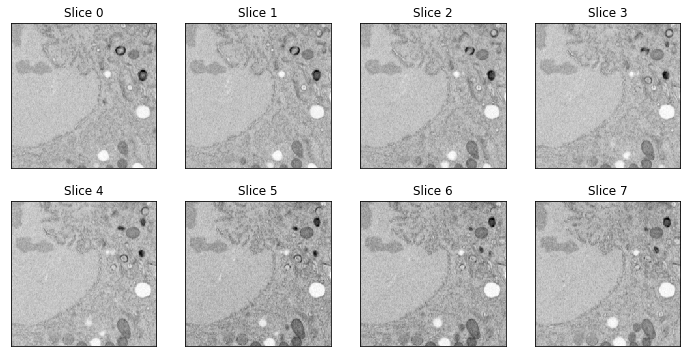

In [76]:
#plot a few consecutive images from the xy plane
f, ax = plt.subplots(2, 4, figsize=(12, 6))

i = 0
for y in range(2):
    for x in range(4):
        ax[y, x].imshow(vol[i], cmap='gray')
        ax[y, x].set_xticks([])
        ax[y, x].set_yticks([])
        ax[y, x].set_title(f'Slice {i}')
        i += 1

In [77]:
def calculate_hash(image, crop_size, hash_size=8):
    #Creates the dhash for the resized image
    #this guarantees that smaller images are not more likely
    #to be recognized as unique
    return imagehash.dhash(Image.fromarray(image).resize((crop_size, crop_size), 2), hash_size=hash_size).hash

In [80]:
#for simplicity, we'll only consider images from the imaging plane for now
#calculate the difference hashes for each
hashes = np.array([calculate_hash(img, 224, 8).ravel() for img in vol])
print(f'{hashes.shape[0]} hashes of {hashes.shape[1]}-bits each')

#make a list of exemplar images to keep
exemplars = []
exemplar_matches = []
min_distance = 12 #Hamming distance threshold for considering images a match
images = np.copy(vol)

#loop through the hashes and assign images to sets of near duplicates
#until all of the hashes are exhausted
while len(hashes) > 0:
    #the reference hash is the first one in the list
    #of remaining hashes
    ref_hash = hashes[0]

    #a match has Hamming distance less than min_distance
    matches = np.where(np.logical_xor(ref_hash, hashes).sum(1) <= min_distance)[0]

    #choose the first match as the exemplar and add
    #it's filepath to the list. this is random because we
    #permuted the paths earlier. a different image could be
    #chosen on another run of this script
    
    #NOTE: just for demonstration purposes
    #the selection of the exemplar is deterministic
    #(i.e. always the first in the group).
    #in the real deduplication script, the
    #images are permutated to be in a random order
    exemplars.append(images[matches[0]])
    exemplar_matches.append(images[matches[1:]])

    #remove all the matched images from both hashes and impaths
    hashes = np.delete(hashes, matches, axis=0)
    images = np.delete(images, matches, axis=0)
    
print(f'Extracted {len(exemplars)} exemplars and {sum([em.shape[0] for em in exemplar_matches])} near-duplicates')

224 hashes of 64-bits each
Extracted 36 exemplars and 188 near-duplicates


Text(0.5, 1.0, 'Exemplar images')

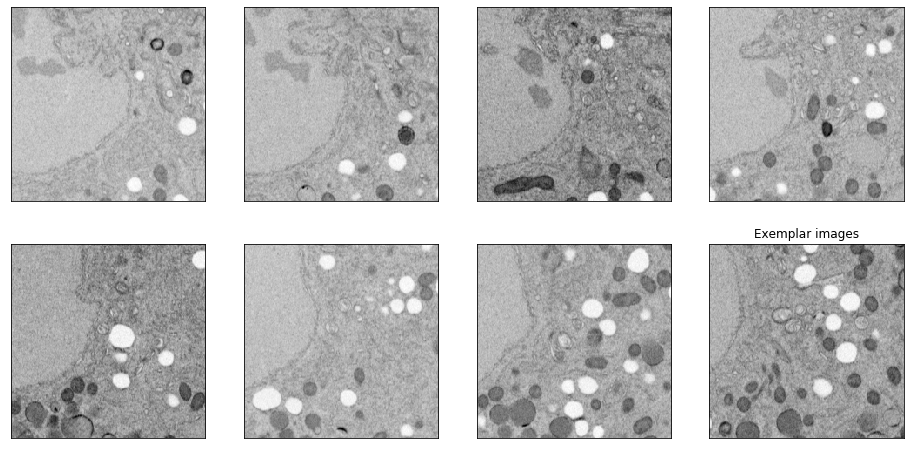

In [83]:
#plot some exemplar images
f, ax = plt.subplots(2, 4, figsize=(16, 8), squeeze=False)

i = 0
for y in range(2):
    for x in range(4):
        ax[y, x].imshow(exemplars[i], cmap='gray')
        ax[y, x].set_xticks([])
        ax[y, x].set_yticks([])
        ax[y, x].set_title(f'Exemplar')
        i += 4

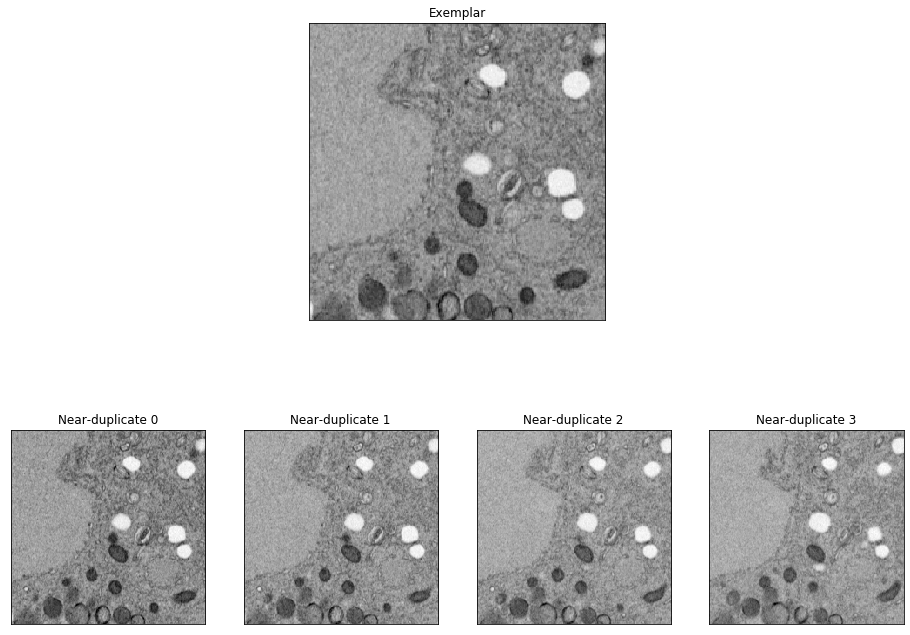

In [82]:
import matplotlib.gridspec as gridspec

index = 14

fig = plt.figure(figsize=(16, 12))
outer = gridspec.GridSpec(2, 1)

inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0], wspace=0, hspace=0)
ax = plt.Subplot(fig, inner[0])
ax.imshow(exemplars[index], cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Exemplar')
fig.add_subplot(ax)

cols = min(6, len(exemplar_matches[index]))
rows = len(exemplar_matches[index]) // cols

inner = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=outer[1])
for x in range(cols * rows):
    ax = plt.Subplot(fig, inner[x])
    ax.imshow(exemplar_matches[index][x], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Near-duplicate {x}')
    fig.add_subplot(ax)